### Step 1: Importing the QFlow class
In Python 3.6 this might return a warning but it can be ignored (it does not affect the accuracy or performance).

In [16]:
# import the QFlow class
import imp
import time
import os

import QFlow_class
imp.reload(QFlow_class)
qf = QFlow_class.QFlow()

### Step 2: Create random subregions for training

The following two cells need to be run only once, as the created training data set is stored locally in the folder `Data/sub_images`. Upon execution, the user is asked to choose the type of data one intends to work with (`'current_map'` or `'sensor_map'`). The argument `sub_size` allows setting the subregion size. It needs to be consistent with the `cnn_model_fn`.

The `path_data` argument allows to specify where the `raw_data.zip file` is -- if the `raw_data.zip` file is in the same folder as `QFlow training` use `path_data = os.getcwd()`. Otherwise, specify where the file is located. 

The progress of extracting and slicing data is visualized with a progress bar. Total time to generate 10 subregions, 30 x 30 pixels, per each data file on a 2017 MacBook Pro is about 7 minutes.

In [17]:
path_data = os.getcwd()
qf.data_selection()

Please choose:                          
	1 for working with current data                          
	2 for working with sensor data.                          
Your choice: 1
You chose to work with the current map.
Please, specify the size of the subregions:30
Please, specify the number of subrigon to generate per full map: 10


In [3]:
qf.slice_data(path_data = path_data)

Extracting raw_data.zip
Progress: |██████████████████████████████████████████████████| 100.0% Complete
raw_data.zip is now extracted
Generating subregions
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Done generating subregions


### Step 2a: Previewing the subregions
This cell allows to preview the training data together with the label for a given subregion. The format of the label is `[No dot, SD, DD]` and it represents the percentage of the subregion area taken by a gien state.  

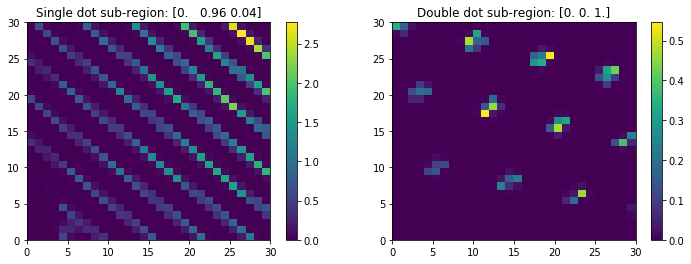

In [9]:
qf.data_preview()

### Step 3: Definition of the learning network

Network parameters, such as the number of convolutional and pooling layers and the number and size of dense layers can be modified to improve the performance of the network. With the default architecture, on a 2017 MacBook Pro the network trains on 30 x 30 pixel subregions to the accuracy of about 96% in about 10 minutes, with accuracy defined as the percentage of correctly classified subregions.


In [10]:
"""Convolutional Neural Network Estimator for 5-gates device."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import glob
import os

tf.logging.set_verbosity(tf.logging.INFO)
    
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    input_layer = tf.cast(tf.reshape(features["x"], [-1, qf.SUB_SIZE, qf.SUB_SIZE, 1]), tf.float32)

    # Convolutional and Pooling Layers
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=16,
        kernel_size=[5, 5],
        padding="same",        # preserves width and height
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=32,
        kernel_size=[5, 5],
        padding="same",        # preserves width and height
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
       
    # Flatten tensor into a batch of vectors
    pool2_flat = tf.contrib.layers.flatten(pool2)

    # Dense Layers
    dense0 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout0 = tf.layers.dropout(inputs=dense0, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    dense1 = tf.layers.dense(inputs=dropout0, units=512, activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    #only for training on current
    dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout2, units=3)

    predictions = {
        "state": tf.argmax(input=logits, axis=1),
        "probabilities": tf.cast(tf.nn.softmax(logits , name="softmax_tensor"), tf.float64)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.mean_squared_error(labels=labels, predictions=tf.nn.softmax(logits))
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
        
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=tf.argmax(labels, axis=1), \
                                                       predictions=predictions["state"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Step 4: Execution of training and evaluation on simulated data

The code reads the subregion data and splits it into two sets (90% for training, 10% for evaluation). Then, using the `cnn_model_fn`, the network is trained to distinguish between single dots, double dots, short circuit and barrier states. The trained network is stored in the `Data/trained_model` folder (created during training). To re-train the network on a new data set this folder needs to be removed or emptied. The outcome from the network is a probability vector in the format `[No dot, SD, DD]`. 

In [6]:
# create the estimator and a place to store the trained network
state_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="Data/trained_model")

#train the network
qf.train_net(classifier=state_classifier, batch_size=50, steps=5000)
qf.eval_net(classifier=state_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Data/trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb23da2470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Total number of samples : 10010
Training samples : 9009
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Ins

INFO:tensorflow:loss = 0.0023311786, step = 3701 (7.235 sec)
INFO:tensorflow: (3.604 sec)
INFO:tensorflow:global_step/sec: 13.929
INFO:tensorflow: (3.576 sec)
INFO:tensorflow:loss = 0.0020768761, step = 3801 (7.180 sec)
INFO:tensorflow: (3.606 sec)
INFO:tensorflow:global_step/sec: 13.7528
INFO:tensorflow: (3.665 sec)
INFO:tensorflow:loss = 0.0019212918, step = 3901 (7.271 sec)
INFO:tensorflow: (3.633 sec)
INFO:tensorflow:global_step/sec: 13.8798
INFO:tensorflow: (3.572 sec)
INFO:tensorflow:loss = 0.0022794358, step = 4001 (7.205 sec)
INFO:tensorflow: (3.671 sec)
INFO:tensorflow:global_step/sec: 13.6096
INFO:tensorflow: (3.677 sec)
INFO:tensorflow:loss = 0.0027549625, step = 4101 (7.348 sec)
INFO:tensorflow: (3.662 sec)
INFO:tensorflow:global_step/sec: 13.7987
INFO:tensorflow: (3.585 sec)
INFO:tensorflow:loss = 0.0014241621, step = 4201 (7.247 sec)
INFO:tensorflow: (3.658 sec)
INFO:tensorflow:global_step/sec: 13.7854
INFO:tensorflow: (3.596 sec)
INFO:tensorflow:loss = 0.0016538921, step

### Step 5: Visualization of the classification accuracy for evaluation
A histogram showing the comparison of true data labels from the evaluation set (evals) and the labels predicted by the trained network (preds). The vertical axis represents the number of images.

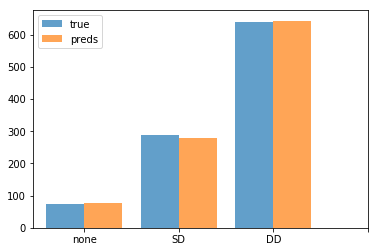

In [11]:
qf.evaluation_visual()

### Step 6: Evaluation of the trained network on experimental data (only for current data)

The code reads the provided experimental data from a folder `Data/exp_data` and then applies the trained network to classify each image. The README file explains how data needs to be formated to be compatible with the network.  

In [18]:
# assign the estimator
tf.logging.set_verbosity(tf.logging.ERROR)
state_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="Data/trained_model")

# evaluate the experimental data
exp_preds = qf.eval_exp(scaling = 20, classifier=state_classifier)
qf.exp_visual(exp_preds = exp_preds)

NameError: name 'scaling' is not defined